In [1]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

train_path = "/kaggle/input/vehicle-detection/train/Final Train Dataset"

data = []
bad_files = []

for file in os.listdir(train_path):
    if file.endswith(".xml"):
        xml_path = os.path.join(train_path, file)
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()

            filename = root.find("filename").text

            size = root.find("size")
            img_width = int(size.find("width").text)
            img_height = int(size.find("height").text)

            for obj in root.findall("object"):
                label = obj.find("name").text
                bbox = obj.find("bndbox")
                xmin = int(bbox.find("xmin").text)
                ymin = int(bbox.find("ymin").text)
                xmax = int(bbox.find("xmax").text)
                ymax = int(bbox.find("ymax").text)

                data.append([filename, img_width, img_height, label, xmin, ymin, xmax, ymax])

        except ET.ParseError:
            bad_files.append(file)

df = pd.DataFrame(data, columns=["filename", "width", "height", "class", "xmin", "ymin", "xmax", "ymax"])
df.to_csv("/kaggle/working/vehicle_annotations.csv", index=False)

print("✅ Parsed annotations:", len(df))
print("⚠️ Bad XML files:", len(bad_files))
print(bad_files[:10])  # show first 10 problematic files
df.head()


✅ Parsed annotations: 24368
⚠️ Bad XML files: 1
['231.xml']


,filename,width,height,class,xmin,ymin,xmax,ymax
0,Numan_(470).jpg,1080,1920,suv,3,475,335,873
1,Numan_(470).jpg,1080,1920,three wheelers (CNG),778,595,838,668
2,Numan_(470).jpg,1080,1920,three wheelers (CNG),885,596,941,666
3,Numan_(470).jpg,1080,1920,three wheelers (CNG),955,597,1003,663
4,Numan_(470).jpg,1080,1920,car,731,606,782,656


In [2]:
import os
import xml.etree.ElementTree as ET

# Path to training folder containing images + XML files
train_folder = "/kaggle/input/vehicle-detection/train/Final Train Dataset"

class_names = set()

for file in os.listdir(train_folder):
    if file.endswith(".xml"):
        xml_path = os.path.join(train_folder, file)
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()
            for obj in root.findall("object"):
                class_names.add(obj.find("name").text.strip())
        except:
            print(f"⚠️ Error parsing {file}")

# Convert set to sorted list
class_list = sorted(list(class_names))

print("✅ Found Classes:", class_list)
print("Total classes:", len(class_list))


⚠️ Error parsing 231.xml
✅ Found Classes: ['ambulance', 'army vehicle', 'auto rickshaw', 'bicycle', 'bus', 'car', 'garbagevan', 'human hauler', 'minibus', 'minivan', 'motorbike', 'pickup', 'policecar', 'rickshaw', 'scooter', 'suv', 'taxi', 'three wheelers (CNG)', 'truck', 'van', 'wheelbarrow']
Total classes: 21


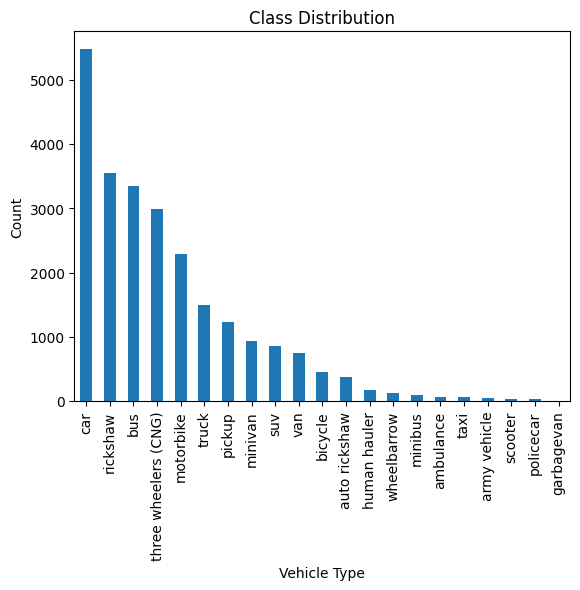

In [3]:
import matplotlib.pyplot as plt

df['class'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Vehicle Type")
plt.ylabel("Count")
plt.show()


In [4]:
import os
import xml.etree.ElementTree as ET

# Convert VOC to YOLO format
def voc_to_yolo(size, box):
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    return x * dw, y * dh, w * dw, h * dh

# ==== CONFIGURATION ====
xml_dir = "/kaggle/input/vehicle-detection/train/Final Train Dataset"
output_dir = "/kaggle/working/yolo_labels_6classes"
os.makedirs(output_dir, exist_ok=True)

# Only keep these 6 classes (and map them to new IDs 0–5)
# Format: "original class name": new_id
class_map = {
    'car': 0,
    'bus': 1,
    'motorbike': 2,
    'truck': 3,
    'auto rickshaw': 4,
    'bicycle': 5
}

# ==== CONVERSION ====
for xml_file in os.listdir(xml_dir):
    if not xml_file.endswith(".xml"):
        continue

    xml_path = os.path.join(xml_dir, xml_file)

    try:
        if os.path.getsize(xml_path) == 0:
            print(f"Skipping {xml_file}: Empty file")
            continue

        tree = ET.parse(xml_path)
        root = tree.getroot()

        size = root.find("size")
        if size is None:
            print(f"Skipping {xml_file}: No <size> tag")
            continue

        w = size.find("width")
        h = size.find("height")
        if w is None or h is None:
            print(f"Skipping {xml_file}: Missing width/height")
            continue

        w, h = int(w.text), int(h.text)
        if w == 0 or h == 0:
            print(f"Skipping {xml_file}: Width/Height is zero")
            continue

        txt_file = os.path.join(output_dir, xml_file.replace(".xml", ".txt"))
        with open(txt_file, "w") as out_file:
            for obj in root.findall("object"):
                cls = obj.find("name").text.strip()
                if cls not in class_map:
                    continue  # Skip unwanted classes

                cls_id = class_map[cls]
                xmlbox = obj.find("bndbox")
                b = (
                    float(xmlbox.find("xmin").text),
                    float(xmlbox.find("xmax").text),
                    float(xmlbox.find("ymin").text),
                    float(xmlbox.find("ymax").text)
                )
                bb = voc_to_yolo((w, h), b)
                out_file.write(f"{cls_id} {' '.join(map(str, bb))}\n")

        print(f"✅ Converted: {xml_file} → {txt_file}")

    except ET.ParseError:
        print(f"⚠️ Skipping {xml_file}: XML parsing error")
    except Exception as e:
        print(f"⚠️ Skipping {xml_file}: {e}")

print("🎯 Conversion complete. Only 6 classes included.")


✅ Converted: Numan_(470).xml → /kaggle/working/yolo_labels_6classes/Numan_(470).txt
✅ Converted: Pias (222).xml → /kaggle/working/yolo_labels_6classes/Pias (222).txt
✅ Converted: Dipto_759.xml → /kaggle/working/yolo_labels_6classes/Dipto_759.txt
✅ Converted: Navid_40.xml → /kaggle/working/yolo_labels_6classes/Navid_40.txt
✅ Converted: Numan_(49).xml → /kaggle/working/yolo_labels_6classes/Numan_(49).txt
✅ Converted: Dipto_ 61.xml → /kaggle/working/yolo_labels_6classes/Dipto_ 61.txt
✅ Converted: Pias (470).xml → /kaggle/working/yolo_labels_6classes/Pias (470).txt
✅ Converted: Numan_(427).xml → /kaggle/working/yolo_labels_6classes/Numan_(427).txt
✅ Converted: Dipto_417.xml → /kaggle/working/yolo_labels_6classes/Dipto_417.txt
✅ Converted: Navid_415.xml → /kaggle/working/yolo_labels_6classes/Navid_415.txt
✅ Converted: Pias (244).xml → /kaggle/working/yolo_labels_6classes/Pias (244).txt
✅ Converted: Pias (476).xml → /kaggle/working/yolo_labels_6classes/Pias (476).txt
✅ Converted: Pias (184).

In [5]:
import shutil

shutil.make_archive("/kaggle/working/yolo_labels_6classes", 'zip', output_dir)


'/kaggle/working/yolo_labels_6classes.zip'

In [6]:
import os, shutil, random

# ==== PATHS ====
images_dir = "/kaggle/input/vehicle-detection/train/Final Train Dataset"  # original images
labels_dir = "/kaggle/working/yolo_labels_6classes"  # <-- new 6-class labels folder from conversion script
output_dir = "/kaggle/working/dataset_6classes"

# Create train/val folders
for split in ['train', 'val']:
    os.makedirs(f"{output_dir}/{split}/images", exist_ok=True)
    os.makedirs(f"{output_dir}/{split}/labels", exist_ok=True)

# Get all label files
label_files = [f for f in os.listdir(labels_dir) if f.endswith(".txt")]

# Train/Val split (80% train, 20% val)
random.seed(42)
random.shuffle(label_files)
split_idx = int(len(label_files) * 0.8)
train_files = label_files[:split_idx]
val_files = label_files[split_idx:]

def copy_files(files, split):
    for file in files:
        # Find matching image
        base_name = file.replace(".txt", "")
        found_image = None
        for ext in [".jpg", ".png", ".jpeg", ".JPG", ".PNG", ".JPEG"]:
            img_path = os.path.join(images_dir, base_name + ext)
            if os.path.exists(img_path):
                found_image = img_path
                break
        
        if not found_image:
            print(f"⚠️ Missing image for {file}, skipping.")
            continue
        
        # Copy label and image
        shutil.copy(os.path.join(labels_dir, file), f"{output_dir}/{split}/labels/{file}")
        shutil.copy(found_image, f"{output_dir}/{split}/images/{os.path.basename(found_image)}")

copy_files(train_files, "train")
copy_files(val_files, "val")

print(f"✅ Train images: {len(os.listdir(f'{output_dir}/train/images'))}")
print(f"✅ Val images: {len(os.listdir(f'{output_dir}/val/images'))}")


✅ Train images: 2400
✅ Val images: 600


In [7]:
import shutil

# Path to your final 6-class dataset folder
dataset_path = "/kaggle/working/dataset_6classes"

# Create a ZIP file
shutil.make_archive("/kaggle/working/dataset_6classes", 'zip', dataset_path)

print("✅ Dataset zipped successfully! You can now download 'dataset_6classes.zip' from the Kaggle Output section.")


✅ Dataset zipped successfully! You can now download 'dataset_6classes.zip' from the Kaggle Output section.


In [8]:
data_yaml = """
train: /kaggle/working/dataset_6classes/train/images
val: /kaggle/working/dataset_6classes/val/images

nc: 6
names: ['bus', 'car', 'motorbike', 'rickshaw', 'three wheelers (CNG)', 'truck']
"""

with open('/kaggle/working/data.yaml', 'w') as f:
    f.write(data_yaml)

print("✅ data.yaml file created at /kaggle/working/data.yaml")


✅ data.yaml file created at /kaggle/working/data.yaml


In [10]:
!zip data_yaml.zip /kaggle/working/data.yaml



  adding: kaggle/working/data.yaml (deflated 33%)


In [11]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall

In [12]:
from ultralytics import YOLO

# Load the small YOLOv8 model
model = YOLO('yolov8s.pt')

# Train the model for 40 epochs
model.train(
    data='/kaggle/working/data.yaml',  # path to your dataset yaml file
    epochs=40,
    imgsz=640,           # you can change image size if needed
    batch=16,            # adjust batch size according to your GPU memory
    name='yolov8s_train_40epochs'  # optional: experiment name for saving
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s_train_40epochs, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=T

Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2219.5±609.5 MB/s, size: 627.9 KB)


train: Scanning /kaggle/working/dataset_6classes/train/labels... 2400 images, 136 backgrounds, 0 corrupt: 100%|██████████| 2400/2400 [00:07<00:00, 310.49it/s] 

train: /kaggle/working/dataset_6classes/train/images/144.jpg: corrupt JPEG restored and saved
train: /kaggle/working/dataset_6classes/train/images/145.jpg: corrupt JPEG restored and saved
train: /kaggle/working/dataset_6classes/train/images/146.jpg: corrupt JPEG restored and saved
train: /kaggle/working/dataset_6classes/train/images/147.jpg: corrupt JPEG restored and saved
train: /kaggle/working/dataset_6classes/train/images/148.jpg: corrupt JPEG restored and saved
train: /kaggle/working/dataset_6classes/train/images/150.jpg: corrupt JPEG restored and saved
train: /kaggle/working/dataset_6classes/train/images/151.jpg: corrupt JPEG restored and saved
train: /kaggle/working/dataset_6classes/train/images/152.jpg: corrupt JPEG restored and saved
train: /kaggle/working/dataset_6classes/train/images/153.jpg: corrupt JPEG restored and saved
train: /kaggle/working/dataset_6classes/train/images/154.jpg: corrupt JPEG restored and saved
train: /kaggle/working/dataset_6classes/train/images/155.jpg

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 783.6±408.7 MB/s, size: 790.5 KB)


val: Scanning /kaggle/working/dataset_6classes/val/labels... 600 images, 45 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:02<00:00, 210.66it/s]

val: /kaggle/working/dataset_6classes/val/images/149.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_6classes/val/images/157.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_6classes/val/images/167.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_6classes/val/images/168.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_6classes/val/images/176.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_6classes/val/images/178.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_6classes/val/images/188.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_6classes/val/images/189.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_6classes/val/images/190.jpg: corrupt JPEG restored and saved
val: New cache created: /kaggle/working/dataset_6classes/val/labels.cache


Plotting labels to runs/detect/yolov8s_train_40epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8s_train_40epochs
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      4.15G      1.288      2.428      1.121        143        640: 100%|██████████| 150/150 [00:48<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.02it/s]

                   all        600       2839      0.467       0.32      0.326      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      4.19G      1.308      1.441      1.149        118        640: 100%|██████████| 150/150 [00:47<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.46it/s]


                   all        600       2839      0.477      0.397      0.376      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      4.23G      1.331      1.433      1.169        106        640: 100%|██████████| 150/150 [00:46<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.54it/s]


                   all        600       2839      0.448      0.371      0.357      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      4.26G      1.328      1.368      1.167        132        640: 100%|██████████| 150/150 [00:46<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.58it/s]

                   all        600       2839      0.492      0.384      0.381      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40       4.3G      1.293      1.294      1.156        104        640: 100%|██████████| 150/150 [00:46<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.62it/s]

                   all        600       2839      0.462      0.421      0.404      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      4.34G      1.269      1.237      1.132        114        640: 100%|██████████| 150/150 [00:46<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.39it/s]


                   all        600       2839      0.544      0.457      0.457      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      4.37G      1.262      1.193      1.129        149        640: 100%|██████████| 150/150 [00:46<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.70it/s]


                   all        600       2839      0.575      0.436      0.457      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      4.41G      1.247      1.167      1.121         98        640: 100%|██████████| 150/150 [00:46<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


                   all        600       2839      0.636      0.461      0.493      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      4.45G      1.217      1.114      1.104         87        640: 100%|██████████| 150/150 [00:46<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.59it/s]


                   all        600       2839      0.548      0.484      0.494      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      4.48G      1.186      1.063      1.088        112        640: 100%|██████████| 150/150 [00:46<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.71it/s]


                   all        600       2839      0.596      0.437       0.49      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      4.52G      1.169      1.042      1.085        145        640: 100%|██████████| 150/150 [00:46<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.38it/s]


                   all        600       2839      0.608      0.483      0.519      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      4.55G      1.166       1.03      1.083        106        640: 100%|██████████| 150/150 [00:46<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.62it/s]

                   all        600       2839      0.592      0.516      0.535      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      4.59G      1.142     0.9811      1.067        102        640: 100%|██████████| 150/150 [00:46<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.60it/s]


                   all        600       2839      0.656      0.491      0.544      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      4.63G      1.138     0.9703      1.067        218        640: 100%|██████████| 150/150 [00:46<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.69it/s]


                   all        600       2839      0.647      0.487      0.544      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      4.66G      1.104     0.9235      1.054        153        640: 100%|██████████| 150/150 [00:45<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.69it/s]


                   all        600       2839      0.612      0.523      0.548      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40       4.7G      1.115     0.9251      1.058        164        640: 100%|██████████| 150/150 [00:46<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.47it/s]


                   all        600       2839      0.618      0.527      0.554      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      4.96G      1.096     0.8894      1.038        125        640: 100%|██████████| 150/150 [00:46<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.58it/s]


                   all        600       2839      0.626      0.509      0.556      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40         5G      1.078      0.869      1.038        166        640: 100%|██████████| 150/150 [00:46<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.76it/s]


                   all        600       2839      0.647      0.525      0.571      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      5.03G       1.07     0.8553      1.028         64        640: 100%|██████████| 150/150 [00:46<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.56it/s]


                   all        600       2839      0.678      0.534      0.591      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      5.07G      1.051     0.8385      1.023        105        640: 100%|██████████| 150/150 [00:46<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.67it/s]


                   all        600       2839      0.628      0.561      0.582      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      5.11G      1.042     0.8052      1.018         98        640: 100%|██████████| 150/150 [00:46<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.30it/s]


                   all        600       2839      0.706      0.545      0.593      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      5.14G      1.035     0.8001      1.015         88        640: 100%|██████████| 150/150 [00:45<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.73it/s]


                   all        600       2839      0.692      0.563      0.609      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      5.18G      1.005     0.7715      1.007        162        640: 100%|██████████| 150/150 [00:46<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.67it/s]


                   all        600       2839      0.658      0.569      0.598      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      5.21G       1.01     0.7657      1.007        180        640: 100%|██████████| 150/150 [00:46<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.73it/s]


                   all        600       2839      0.682      0.534        0.6      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      5.25G      1.009     0.7609      1.004        133        640: 100%|██████████| 150/150 [00:46<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.62it/s]


                   all        600       2839      0.725      0.545      0.607       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      5.29G     0.9864     0.7409     0.9923        140        640: 100%|██████████| 150/150 [00:45<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.40it/s]


                   all        600       2839      0.679       0.58      0.612      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      5.32G     0.9855     0.7287     0.9928        118        640: 100%|██████████| 150/150 [00:46<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.66it/s]


                   all        600       2839      0.663      0.579      0.611      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      5.36G     0.9775     0.7135     0.9888        112        640: 100%|██████████| 150/150 [00:46<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.67it/s]


                   all        600       2839      0.729      0.565      0.635      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40       5.4G     0.9606     0.6958     0.9859        202        640: 100%|██████████| 150/150 [00:46<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.57it/s]


                   all        600       2839      0.694      0.572      0.625      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      5.43G     0.9463     0.6799     0.9772         97        640: 100%|██████████| 150/150 [00:46<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


                   all        600       2839      0.691      0.579       0.63      0.387
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      5.47G      0.947     0.6679     0.9653         67        640: 100%|██████████| 150/150 [00:47<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.50it/s]


                   all        600       2839      0.705      0.588       0.63      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      6.06G     0.9198      0.629     0.9525         71        640: 100%|██████████| 150/150 [00:45<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.69it/s]


                   all        600       2839      0.697      0.565       0.61      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      6.09G     0.9134     0.6069     0.9471         45        640: 100%|██████████| 150/150 [00:46<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.68it/s]

                   all        600       2839      0.753      0.559      0.633      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      6.13G      0.911     0.5943     0.9471         46        640: 100%|██████████| 150/150 [00:45<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.65it/s]


                   all        600       2839      0.754      0.568      0.638      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      6.17G     0.8934     0.5782     0.9399         95        640: 100%|██████████| 150/150 [00:45<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.74it/s]


                   all        600       2839      0.723      0.575      0.633      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40       6.2G     0.8837     0.5693     0.9387         83        640: 100%|██████████| 150/150 [00:45<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.50it/s]


                   all        600       2839       0.72      0.588       0.64      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      6.24G     0.8656     0.5501      0.926         72        640: 100%|██████████| 150/150 [00:45<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.82it/s]


                   all        600       2839      0.742      0.582      0.632      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      6.28G     0.8551     0.5357     0.9302         88        640: 100%|██████████| 150/150 [00:45<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.79it/s]


                   all        600       2839      0.724       0.57      0.636      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      6.31G     0.8486     0.5277     0.9244         85        640: 100%|██████████| 150/150 [00:45<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.75it/s]


                   all        600       2839      0.688      0.597      0.639      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      6.35G     0.8374     0.5206     0.9208         66        640: 100%|██████████| 150/150 [00:45<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.84it/s]

                   all        600       2839      0.728       0.57      0.635      0.401



40 epochs completed in 0.579 hours.
Optimizer stripped from runs/detect/yolov8s_train_40epochs/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8s_train_40epochs/weights/best.pt, 22.5MB

Validating runs/detect/yolov8s_train_40epochs/weights/best.pt...
Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.09it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        600       2839      0.717      0.588       0.64      0.401
                   bus        326       1137       0.76      0.647      0.707      0.472
                   car        298        737      0.762      0.665       0.74      0.505
             motorbike        252        492      0.724       0.65      0.683      0.367
              rickshaw        143        285      0.655      0.649      0.667       0.47
  three wheelers (CNG)         32         72      0.765      0.556      0.636      0.398
                 truck         84        116      0.638      0.362      0.408      0.195
Speed: 0.1ms preprocess, 2.9ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/yolov8s_train_40epochs


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e3922e683d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

In [13]:
import shutil

shutil.make_archive("/kaggle/working/yolov8s_train_40epochs", 'zip', "runs/detect/yolov8s_train_40epochs")
print("Zipped training results.")


Zipped training results.


In [14]:

# Load the trained model weights
model = YOLO('/kaggle/working/runs/detect/yolov8s_train_40epochs/weights/best.pt')  # path to your best weights after training

# Run evaluation on the validation set
results = model.val(data='/kaggle/working/data.yaml', imgsz=640, batch=16)

# Print the results
print(results)


Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2065.7±903.5 MB/s, size: 198.8 KB)


val: Scanning /kaggle/working/dataset_6classes/val/labels.cache... 600 images, 45 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<?, ?it/s]

val: /kaggle/working/dataset_6classes/val/images/149.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_6classes/val/images/157.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_6classes/val/images/167.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_6classes/val/images/168.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_6classes/val/images/176.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_6classes/val/images/178.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_6classes/val/images/188.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_6classes/val/images/189.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_6classes/val/images/190.jpg: corrupt JPEG restored and saved



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.01it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        600       2839       0.72      0.581       0.64      0.402
                   bus        326       1137      0.769      0.645      0.708      0.473
                   car        298        737      0.762      0.658       0.74      0.506
             motorbike        252        492      0.737      0.652      0.688      0.365
              rickshaw        143        285      0.658      0.642      0.661       0.47
  three wheelers (CNG)         32         72      0.748      0.528      0.636      0.405
                 truck         84        116      0.646      0.362      0.404      0.192
Speed: 0.3ms preprocess, 4.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e39089f8a90>
curves: ['Precision-Recall

In [15]:
import shutil

shutil.make_archive("/kaggle/working/val", 'zip', "runs/detect/val")
print("Zipped training results.")

Zipped training results.


In [16]:
results = model.predict(source='/kaggle/working/dataset_6classes/val/images', imgsz=640, conf=0.25)

# results.show()  # To display predictions

# Or save predictions to disk
results.save(save_dir='runs/detect/test_predictions')



image 1/600 /kaggle/working/dataset_6classes/val/images/05.jpg: 448x640 7 buss, 1 motorbike, 1 three wheelers (CNG), 40.2ms
image 2/600 /kaggle/working/dataset_6classes/val/images/09.jpg: 352x640 10 buss, 1 car, 1 motorbike, 39.9ms
image 3/600 /kaggle/working/dataset_6classes/val/images/102.jpg: 320x640 4 buss, 4 motorbikes, 38.6ms
image 4/600 /kaggle/working/dataset_6classes/val/images/105.jpg: 640x480 3 buss, 38.7ms
image 5/600 /kaggle/working/dataset_6classes/val/images/107.jpg: 640x480 1 bus, 1 car, 1 motorbike, 6.8ms
image 6/600 /kaggle/working/dataset_6classes/val/images/116.jpg: 640x480 1 bus, 2 cars, 6.8ms
image 7/600 /kaggle/working/dataset_6classes/val/images/120.jpg: 640x384 3 buss, 2 cars, 1 motorbike, 39.6ms
image 8/600 /kaggle/working/dataset_6classes/val/images/125.jpg: 640x384 2 buss, 2 cars, 7.9ms
image 9/600 /kaggle/working/dataset_6classes/val/images/127.jpg: 640x384 1 bus, 2 cars, 1 motorbike, 7.9ms
image 10/600 /kaggle/working/dataset_6classes/val/images/129.jpg: 

AttributeError: 'list' object has no attribute 'save'